# Movie Reviews dataset

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from src.settings import DATA_DIR

DATA_DIR = DATA_DIR.joinpath('movie_reviews')

df_train = pd.read_csv(DATA_DIR.joinpath('train.tsv'), sep='\t')
df_dev = pd.read_csv(DATA_DIR.joinpath('dev.tsv'), sep='\t')
df_test = pd.read_csv(DATA_DIR.joinpath('test.tsv'), sep='\t')

In [3]:
df_train.head()

,sentence,label
0,the film sparkles with the the wisdom and humo...,1
1,the cast is uniformly excellent . . . but the ...,0
2,a film that's flawed and brilliant in equal me...,1
3,"if you're looking for comedy to be served up ,...",0
4,don't expect any subtlety from this latest ent...,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8534 entries, 0 to 8533
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  8534 non-null   object
 1   label     8534 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.5+ KB


In [5]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1078 non-null   object
 1   label     1078 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1050 non-null   object
 1   label     1050 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.5+ KB


### Concat all splits

In [7]:
df_train['split'] = 'train'
df_dev['split'] = 'val'
df_test['split'] = 'test'
df_all = pd.concat([df_train, df_dev, df_test], ignore_index=True)

### Label distribution

Unique labels: [1 0]


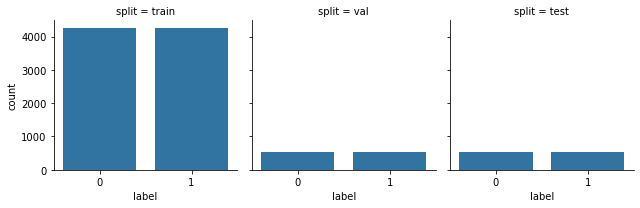

In [8]:
print(f'Unique labels: {df_all.label.unique()}')

g = sns.FacetGrid(df_all, col="split")
g.map(sns.countplot, 'label', order=[0, 1])

### Text length

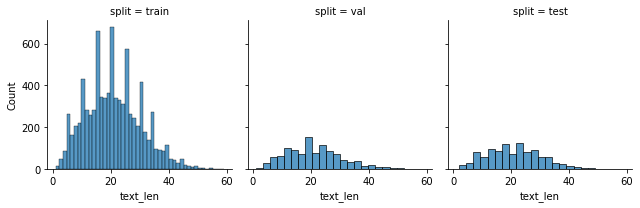

In [9]:
df_all['text_len'] = df_all.sentence.apply(lambda x: len(x.split(' ')))

g = sns.FacetGrid(df_all, col="split")
g.map(sns.histplot, 'text_len')

In [10]:
df_all.describe()

,label,text_len
count,10662.000000,10662.000000
mean,0.500000,21.015382
std,0.500023,9.411835
min,0.000000,1.000000
25%,0.000000,14.000000
50%,0.500000,20.000000
75%,1.000000,27.000000
max,1.000000,59.000000


### Tokenized text lengths

In [11]:
from transformers import AutoTokenizer

HUGGINGFACE_MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(HUGGINGFACE_MODEL_NAME, do_lower_case=True)

texts = df_all['sentence'].values.tolist()

text_tokenized = tokenizer(
    texts,
    add_special_tokens=True,
    return_token_type_ids=False,
    return_attention_mask=False,
    truncation=False,
    padding=False,
    return_length=True
)
text_tokens = text_tokenized['input_ids']
lengths = text_tokenized['length']

df_all['tok_len'] = lengths
df_all.head()

,sentence,label,split,text_len,tok_len
0,the film sparkles with the the wisdom and humo...,1,train,13,16
1,the cast is uniformly excellent . . . but the ...,0,train,17,20
2,a film that's flawed and brilliant in equal me...,1,train,10,15
3,"if you're looking for comedy to be served up ,...",0,train,14,18
4,don't expect any subtlety from this latest ent...,0,train,16,25


In [12]:
df_all.describe()

,label,text_len,tok_len
count,10662.000000,10662.000000,10662.000000
mean,0.500000,21.015382,28.835022
std,0.500023,9.411835,12.091407
min,0.000000,1.000000,3.000000
25%,0.000000,14.000000,20.000000
50%,0.500000,20.000000,28.000000
75%,1.000000,27.000000,37.000000
max,1.000000,59.000000,82.000000


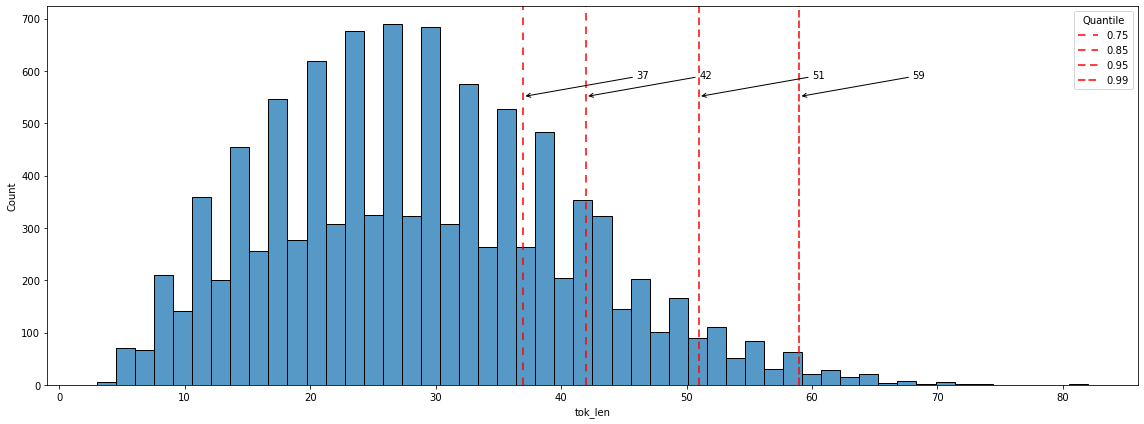

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 6))

sns.histplot(x='tok_len', data=df_all, ax=ax)
max_val = max([p.get_height() for p in ax.patches])
for q, ls in zip([0.75, 0.85, 0.95, 0.99], [(0, (5, 5)), (0, (5, 4)), (0, (5, 3)), (0, (5, 2))]):
    qv = int(df_all['tok_len'].quantile(q))
    ax.axvline(qv, color='red', ls=ls, lw=1.5, label=q)
    ax.annotate(
        qv,
        xy=(qv, max_val * 0.8),
        xytext=(qv + 9, max_val * 0.85),
        arrowprops=dict(arrowstyle="->", color='black'),
    )

ax.legend(title='Quantile')

fig.tight_layout()